* cluster head
* client_ratio
* non-IID data
* DBSCAN
* batch size
* plot

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import unique
from numpy import where
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Sequential
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import random
from itertools import accumulate

In [ ]:
# Global variablles
TOT_CLIENTS = 100
learning_rate_list = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
NUM_ROUNDS = 10
CLIENT_RATIO = 0.3
DATA_DIV = 6000
NUM_CLIENTS = int(TOT_CLIENTS * CLIENT_RATIO)
div_list = [np.random.randint(3000,6000) for i in range(NUM_CLIENTS)]
origin_list = [np.random.randint(0,123573) for i in range(NUM_CLIENTS)]

In [ ]:
div_list

[4031,
 2570,
 3696,
 1208,
 3595,
 2210,
 3199,
 2292,
 3031,
 2393,
 2262,
 1159,
 2611,
 3218,
 1617,
 3740,
 3403,
 2359,
 1675,
 1706,
 2472,
 4063,
 4545,
 1962,
 4494,
 1978,
 4508,
 2134,
 1927,
 4009]

In [ ]:
origin_list

[37065,
 46004,
 41714,
 5856,
 44293,
 46109,
 6116,
 23312,
 26596,
 8594,
 21664,
 9524,
 15859,
 21763,
 51763,
 46010,
 54772,
 25264,
 7720,
 45888,
 15787,
 41824,
 14333,
 10803,
 20873,
 35498,
 40576,
 11949,
 21028,
 1697]

# Data Loading and Preprocessing

In [ ]:
#loading data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

#reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalixation
X_train /= 255
X_test /= 255

# One Hot encoding
ohe = OneHotEncoder(sparse=False)
y_train=ohe.fit_transform(y_train.reshape(-1, 1))
y_test=ohe.transform(y_test.reshape(-1, 1))

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
client_train_x = []
client_train_y = []

for i in range(NUM_CLIENTS):
  client_train_x.append(X_train[origin_list[i]:origin_list[i]+div_list[i]])
  client_train_y.append(y_train[origin_list[i]:origin_list[i]+div_list[i]])

In [ ]:
for num in range(10):
  print(div_list[num]*num, div_list[num]*(num+1))

0 4031
2570 5140
7392 11088
3624 4832
14380 17975
11050 13260
19194 22393
16044 18336
24248 27279
21537 23930


# Model Function

In [ ]:
def create_server_model():

  model=Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), input_shape = (28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

# Model Cloner

In [ ]:
def model_cloner(model, learning_rate, optimizer):
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())
    if optimizer=='adam':
        new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

# Initial Training

In [ ]:
def train_client_initial(num, model, lr_list):
  models = []
  losses = []

  for i in range(len(lr_list)):
    models.append(model_cloner(model, lr_list[i], 'adam'))
    hist = models[i].fit(client_train_x[num], client_train_y[num], epochs=1, batch_size=32, validation_data=(X_test, y_test))
    losses.append(round(hist.history['val_loss'][0], 4))

  ind = losses.index(min(losses))

  return models[ind], lr_list[ind], losses[ind]

In [ ]:
server_model = create_server_model()
server_model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
server_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_init = []
losses = []
data = []
client_models = []

for j in range(NUM_CLIENTS):
  print("----------------CLIENT " + str(j) +"-------------------------")

  lr_list = np.random.choice(learning_rate_list, 3, replace=False)
  data.append(train_client_initial(j, server_model, lr_list))

  client_models.append(data[j][0])
  lr_init.append(data[j][1])
  losses.append(data[j][2])

sum=[i*0 for i in client_models[0].get_weights()]
for i in range(NUM_CLIENTS):
  sum = [i+j for i, j in zip(client_models[i].get_weights(), sum)]
server_model.set_weights([i/NUM_CLIENTS for i in sum])

----------------CLIENT 0-------------------------
126/126 [==============================] - 1s 9ms/step - loss: 2.3273 - accuracy: 0.0817 - val_loss: 2.3177 - val_accuracy: 0.0911
----------------CLIENT 1-------------------------
81/81 [==============================] - 1s 12ms/step - loss: 2.3351 - accuracy: 0.0779 - val_loss: 2.3241 - val_accuracy: 0.0871
----------------CLIENT 2-------------------------
116/116 [==============================] - 1s 9ms/step - loss: 0.8153 - accuracy: 0.7337 - val_loss: 0.3400 - val_accuracy: 0.8932
----------------CLIENT 3-------------------------
38/38 [==============================] - 1s 23ms/step - loss: 2.3324 - accuracy: 0.0710 - val_loss: 2.3298 - val_accuracy: 0.0824
----------------CLIENT 4-------------------------
113/113 [==============================] - 1s 10ms/step - loss: 2.3350 - accuracy: 0.0774 - val_loss: 2.3197 - val_accuracy: 0.0906
----------------CLIENT 5-------------------------
70/70 [==============================] - 1s 14

In [ ]:
server_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7891 - accuracy: 0.8330


[0.7496039271354675, 0.848800003528595]

# Clustering

In [ ]:
from sklearn.cluster import DBSCAN

#lr_init = [0.01, 0.1, 0.00001, 0.001, 0.001, 0.0001, 0.1, 0.001, 0.00001, 0.000001]
lr_init1 = np.reshape(lr_init, (-1,1))
#print(lr_init)

model = DBSCAN(eps=0.0001, min_samples=2)
yhat = model.fit_predict(lr_init1)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
print(yhat)

[0 1 1 2 0 1 1 2 2 2 1 1 2 2 1 2 1 2 2 1 1 1 2 1 0 1 0 1 1 1]


# Genetic Mutation

In [ ]:
def mutate(lr):

    num = random.randint(-1,1)
    lr += (lr/10)*num

    return lr

# Genetic Mating

In [ ]:
def crossover(lrs):
  new_lrs = []

  new_lrs.append(lrs[0])
  if(len(lrs) >1):
    new_lrs.append(lrs[1])

  if(len(lrs) > 2):
    for i in range(2, len(lrs)):
      parentA = random.randint(0, len(lrs)-1)
      parentB = random.randint(0, len(lrs)-1)

      new_lrs.append(mutate((lrs[parentA]+lrs[parentB])/2))

  return new_lrs

# Genetic Evolution

In [ ]:
def evolve(losses, lrs):
    sorted_y_idx_list = sorted(range(len(losses)),key=lambda x:losses[x])
    lrs = [lrs[i] for i in sorted_y_idx_list]
    lrs = crossover(lrs)

    return lrs

# Edge Device training

In [ ]:
def train_client(num, model, lr):

  new_model = model_cloner(model, lr, 'adam')
  hist = new_model.fit(client_train_x[num], client_train_y[num], epochs=2, batch_size=32, validation_data=(X_test, y_test))

  return new_model, lr, round(hist.history['val_loss'][-1], 4)


In [ ]:
losses 

[2.1555,
 0.2814,
 0.34,
 0.5186,
 2.1793,
 0.3871,
 0.3577,
 0.3962,
 0.3425,
 0.3834,
 0.3624,
 0.5723,
 0.4147,
 0.3527,
 0.4291,
 0.3413,
 0.3268,
 0.4784,
 0.4659,
 0.3755,
 0.3293,
 0.242,
 0.2985,
 0.3668,
 0.7032,
 0.382,
 0.6833,
 0.3015,
 0.452,
 0.2776]

In [ ]:
lr_init 

[1e-05,
 0.01,
 0.01,
 0.001,
 1e-05,
 0.01,
 0.01,
 0.001,
 0.001,
 0.001,
 0.01,
 0.01,
 0.001,
 0.001,
 0.01,
 0.001,
 0.01,
 0.001,
 0.001,
 0.01,
 0.01,
 0.01,
 0.001,
 0.01,
 0.0001,
 0.01,
 0.0001,
 0.01,
 0.01,
 0.01]

In [ ]:
yhat
if(-1 in yhat):
  flag=1
else:
  flag=0

# Genetic Clustering FL

In [ ]:
yhat = list(yhat)
serverhist1={
    "loss": list(),
    "accuracy": list()
}
# Control loop
for i in range(NUM_ROUNDS):
  print("---------"+str(i)+"------------")
  lr_global = []
  #  Genetic Optimization of Hyper-Parameters
  for cluster in clusters:
    ind = [k for k in range(len(yhat)) if(yhat[k]==cluster)]
    lr_global.append(evolve([losses[k] for k in ind], [lr_init[k] for k in ind]))

  lr_init = []
  losses = []
  data = []
  lrid = np.zeros(len(clusters))
  for j in range(NUM_CLIENTS):
    print(lrid)
    data.append(train_client(j, server_model, lr_global[yhat[j]+flag][int(lrid[yhat[j]+flag])]))
    lrid[yhat[j]+flag] +=1

    client_models[j] = data[j][0]
    losses.append(data[j][2])
    lr_init.append(data[j][1])

  # Cluster head aggregation
  n_clust = len(set(yhat))
  a = [[i*0 for i in client_models[0].get_weights()] for i in range(n_clust)]
  for i in range(len(yhat)):
    a[yhat[i]] = [k+j for k, j in zip(client_models[i].get_weights(), a[yhat[i]])]


  # Aggregating model
  sum=[i*0 for i in client_models[0].get_weights()]
  for i in range(len(a)):
    sum = [i+j for i, j in zip(a[i], sum)]
  server_model.set_weights([i/NUM_CLIENTS for i in sum])

  # Model Evaluation
  h=server_model.evaluate(X_test,y_test)
  serverhist1['loss'].append(h[1])
  serverhist1['accuracy'].append(h[0])

---------0------------
[0. 0. 0.]
Epoch 1/2
126/126 [==============================] - 1s 9ms/step - loss: 0.5922 - accuracy: 0.8675 - val_loss: 0.2811 - val_accuracy: 0.9247
Epoch 2/2
126/126 [==============================] - 1s 8ms/step - loss: 0.2804 - accuracy: 0.9183 - val_loss: 0.2413 - val_accuracy: 0.9285
[1. 0. 0.]
Epoch 1/2
81/81 [==============================] - 1s 12ms/step - loss: 0.5271 - accuracy: 0.8484 - val_loss: 0.2994 - val_accuracy: 0.9073
Epoch 2/2
81/81 [==============================] - 1s 11ms/step - loss: 0.1501 - accuracy: 0.9469 - val_loss: 0.3352 - val_accuracy: 0.9110
[1. 1. 0.]
Epoch 1/2
116/116 [==============================] - 1s 9ms/step - loss: 0.4904 - accuracy: 0.8508 - val_loss: 0.3053 - val_accuracy: 0.9112
Epoch 2/2
116/116 [==============================] - 1s 8ms/step - loss: 0.2094 - accuracy: 0.9348 - val_loss: 0.3876 - val_accuracy: 0.9118
[1. 2. 0.]
Epoch 1/2
38/38 [==============================] - 1s 24ms/step - loss: 0.4375 - accuracy

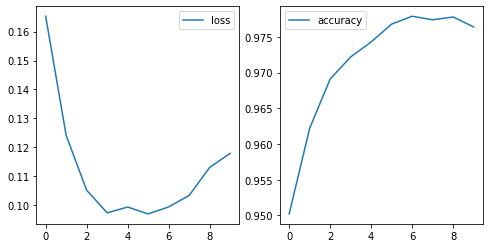

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot(serverhist1['accuracy'], label="loss")
ax.legend()
ax=fig.add_subplot(122)
ax.plot(serverhist1['loss'], label="accuracy")
ax.legend()
plt.savefig("Clustered Genetic FL", dpi=300)
plt.show()

In [ ]:
losses

[0.1075,
 0.7779,
 0.8918,
 0.1106,
 0.1113,
 0.6494,
 0.7049,
 0.1119,
 0.1047,
 0.1113,
 1.1751,
 0.747,
 0.1218,
 0.1234,
 0.759,
 0.1176,
 0.5914,
 0.1086,
 0.1185,
 1.2775,
 0.8511,
 0.9309,
 0.1177,
 1.0025,
 0.11,
 1.6776,
 0.111,
 0.5144,
 1.0596,
 0.5154]

In [ ]:
server_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1179 - accuracy: 0.9764


[0.11790527403354645, 0.9764000177383423]

# Generic FL

In [ ]:
client_models = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

server_model_norm = create_server_model()
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
serverhist={
    "loss":[],
    "accuracy":[]
}

for i in range(NUM_ROUNDS):
  print("-----"+str(i)+"---------")
  losses = []
  lr_init = []
  data= []
  for j in range(NUM_CLIENTS):
    data.append(train_client(j, server_model_norm, 0.0001))

    client_models[j] = data[j][0]
    losses.append(data[j][2])
    lr_init.append(data[j][1])

  # Aggregating model
  sum=[i*0 for i in client_models[0].get_weights()]
  for i in range(NUM_CLIENTS):
    sum = [i+j for i, j in zip(client_models[i].get_weights(), sum)]
  server_model_norm.set_weights([i/NUM_CLIENTS for i in sum])
  h=server_model_norm.evaluate(X_test,y_test)
  serverhist['loss'].append(h[1])
  serverhist['accuracy'].append(h[0])



-----0---------
Epoch 1/2
126/126 [==============================] - 1s 9ms/step - loss: 1.8670 - accuracy: 0.4666 - val_loss: 0.8049 - val_accuracy: 0.8213
Epoch 2/2
126/126 [==============================] - 1s 7ms/step - loss: 0.7000 - accuracy: 0.8381 - val_loss: 0.4888 - val_accuracy: 0.8772
Epoch 1/2
81/81 [==============================] - 1s 12ms/step - loss: 1.9951 - accuracy: 0.4139 - val_loss: 1.1592 - val_accuracy: 0.7848
Epoch 2/2
81/81 [==============================] - 1s 10ms/step - loss: 0.9596 - accuracy: 0.8103 - val_loss: 0.6576 - val_accuracy: 0.8504
Epoch 1/2
116/116 [==============================] - 1s 9ms/step - loss: 1.9199 - accuracy: 0.4610 - val_loss: 0.8611 - val_accuracy: 0.8308
Epoch 2/2
116/116 [==============================] - 1s 8ms/step - loss: 0.7383 - accuracy: 0.8404 - val_loss: 0.4968 - val_accuracy: 0.8802
Epoch 1/2
38/38 [==============================] - 1s 23ms/step - loss: 2.1703 - accuracy: 0.3266 - val_loss: 1.7589 - val_accuracy: 0.6314


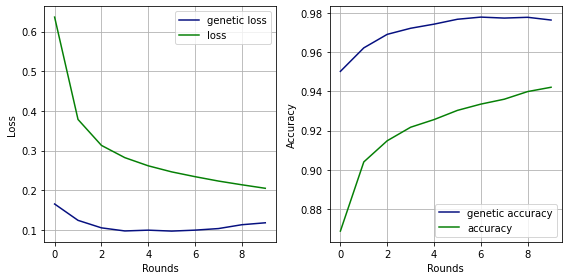

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot(serverhist1['accuracy'], label="genetic loss", color="#061080")
ax.plot(serverhist['accuracy'], label="loss", color="#068006")
ax.legend()
ax.grid(True)
ax.set_xlabel("Rounds")
ax.set_ylabel("Loss")
ax=fig.add_subplot(122)
ax.plot(serverhist1['loss'], label="genetic accuracy", color="#061080")
ax.plot(serverhist['loss'], label="accuracy", color="#068006")
ax.legend()
ax.grid(True)
ax.set_xlabel("Rounds")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.savefig("Generic FL.png", dpi=300)
plt.show()

In [ ]:
from google.colab import files
files.download("Generic FL.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Normal Training

In [ ]:
server_model_norm = create_server_model()
num=0
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
n_hist=server_model_norm.fit(X_train[6000*num:6000*(num+1)], y_train[6000*num:6000*(num+1)], epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
188/188 [==============================] - 2s 7ms/step - loss: 0.8065 - accuracy: 0.7578 - val_loss: 0.2874 - val_accuracy: 0.9135
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2138 - accuracy: 0.9360 - val_loss: 0.2259 - val_accuracy: 0.9333
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.1237 - accuracy: 0.9630 - val_loss: 0.1942 - val_accuracy: 0.9424
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0847 - accuracy: 0.9758 - val_loss: 0.1952 - val_accuracy: 0.9406
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0550 - accuracy: 0.9871 - val_loss: 0.1982 - val_accuracy: 0.9455
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0353 - accuracy: 0.9901 - val_loss: 0.2123 - val_accuracy: 0.9425
Epoch 7/10
188/188 [==============================] - 1s 6ms/step - loss: 0.0183 - accuracy: 0.9970 - val_loss: 0.1875 - val_accuracy: 0.9512
Epoch 

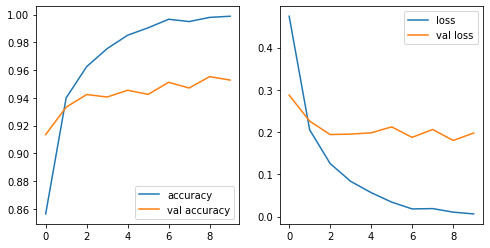

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot(n_hist.history['accuracy'], label="accuracy")
ax.plot(n_hist.history['val_accuracy'], label="val accuracy")
ax.legend()
ax=fig.add_subplot(122)
ax.plot(n_hist.history['loss'], label="loss")
ax.plot(n_hist.history['val_loss'], label="val loss")
ax.legend()
plt.savefig("Generic", dpi=300)
plt.show()